<a href="https://colab.research.google.com/github/mr-nudo/intelligent-tools/blob/master/6_DenoisingAutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt


# Load and Prepare Data

In [7]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.

# Reshape the data to include channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Function to add noise
def add_noise(images, noise_factor=0.5):
    noise = np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise_factor * noise
    return np.clip(noisy_images, 0., 1.)

# Add noise to the images
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)





# Build the Autoencoder Model

In [29]:
# Build the Encoder
def encoder_model(input_shape = (28,28,1)):
    encoder_input = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    # x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # encoder_output = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoder_output = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    encoder = models.Model(encoder_input, encoder_output, name="encoder")
    return encoder

# Build the Decoder
def decoder_model(encoded_shape):
    decoder_input = layers.Input(shape=encoded_shape)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(decoder_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = models.Model(decoder_input, decoder_output, name="decoder")
    return decoder

encoder = encoder_model()
# Print the encoder model summary
encoder.summary()

# Get the shape of the encoder output
encoder_shape = encoder.output.shape[1:]

# Build the decoder
decoder = decoder_model(encoder_shape)

# Print the decoder model summary
decoder.summary()

# Build the Autoencoder
def autoencoder_model(encoder, decoder):
    autoencoder_input = encoder.input
    encoded_output = encoder(autoencoder_input)
    decoded_output = decoder(encoded_output)

    autoencoder = models.Model(autoencoder_input, decoded_output, name="autoencoder")
    return autoencoder

# Build the autoencoder
autoencoder = autoencoder_model(encoder, decoder)

# Print the autoencoder model summary
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_80 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_81 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 7, 7, 128)         7385

# Train the Autoencoder

In [30]:
# Train the Autoencoder
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)



Epoch 1/50
469/469 [==============================] - 16s 19ms/step - loss: 0.3237 - val_loss: 0.3005
Epoch 2/50
469/469 [==============================] - 8s 16ms/step - loss: 0.2946 - val_loss: 0.2943
Epoch 3/50
469/469 [==============================] - 7s 16ms/step - loss: 0.2904 - val_loss: 0.2917
Epoch 4/50
469/469 [==============================] - 7s 15ms/step - loss: 0.2881 - val_loss: 0.2899
Epoch 5/50
469/469 [==============================] - 7s 16ms/step - loss: 0.2864 - val_loss: 0.2881
Epoch 6/50
469/469 [==============================] - 7s 15ms/step - loss: 0.2852 - val_loss: 0.2873
Epoch 7/50
469/469 [==============================] - 7s 15ms/step - loss: 0.2842 - val_loss: 0.2865
Epoch 8/50
469/469 [==============================] - 7s 15ms/step - loss: 0.2833 - val_loss: 0.2858
Epoch 9/50
469/469 [==============================] - 7s 15ms/step - loss: 0.2826 - val_loss: 0.2852
Epoch 10/50
469/469 [==============================] - 7s 15ms/step - loss: 0.2821 - val_l

# Visualise the training and validation loss

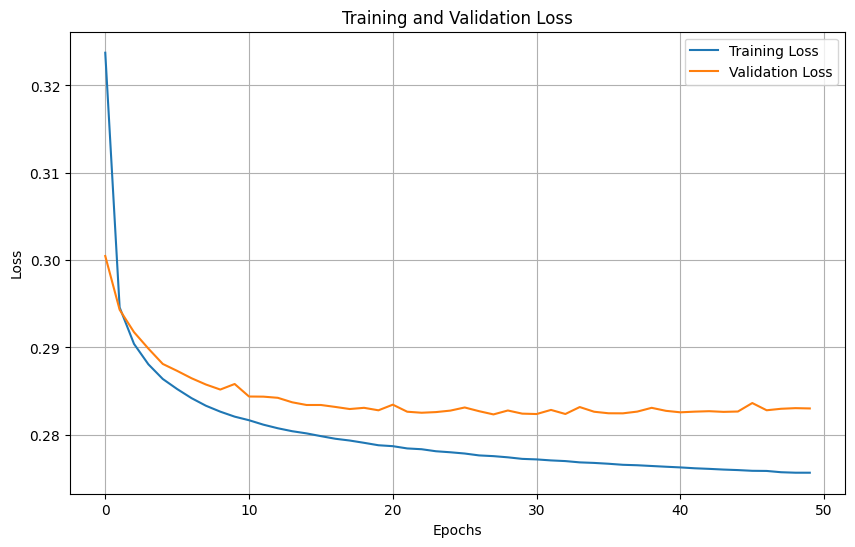

In [31]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate the Results

313/313 [==============================] - 1s 2ms/step


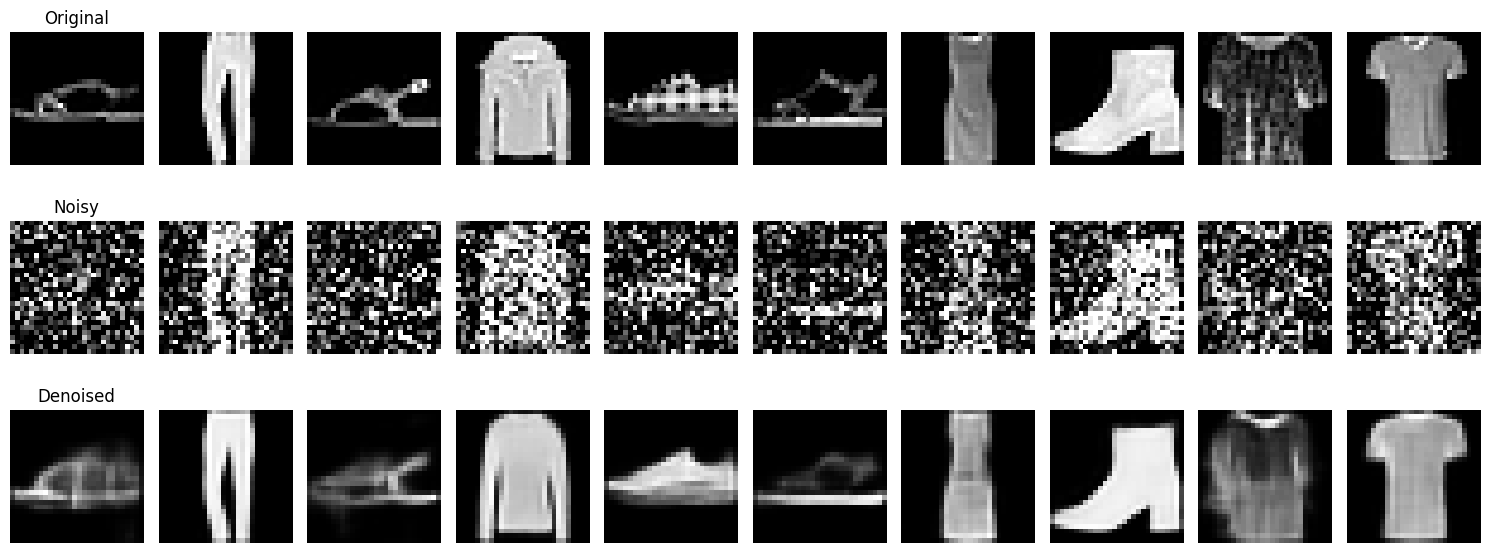

In [32]:
# Visualise the results

# Predict denoised images using the autoencoder
denoised_images = autoencoder.predict(x_test_noisy)

# Select 10 random indices to visualize
indices = np.random.choice(x_test.shape[0], 10, replace=False)

# Extract the original, noisy, and denoised images
original_images = x_test[indices]
noisy_images = x_test_noisy[indices]
denoised_images = denoised_images[indices]

# Plotting the images
plt.figure(figsize=(15, 6))

# Plot original images
for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')

# Plot noisy images
for i in range(10):
    plt.subplot(3, 10, 10 + i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Noisy')

# Plot denoised images
for i in range(10):
    plt.subplot(3, 10, 20 + i + 1)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Denoised')

plt.tight_layout()
plt.show()